<a href="https://colab.research.google.com/github/AdamStajer07/pytorchTutorial/blob/main/PyTorchTutorial4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
import requests
import zipfile
from pathlib import Path

data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

if image_path.is_dir():
  print(f"{image_path} directory already exists")
else:
  print(f"{image_path} directory doesn't exists, creating one...")
  image_path.mkdir(parents=True, exist_ok=True)

with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print("Downloading pizza, steak and sushi data...")
  f.write(request.content)

with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
  print("Unzipping pizza, steak and sushi data")
  zip_ref.extractall(image_path)

data/pizza_steak_sushi directory doesn't exists, creating one...
Unzipping pizza, steak and sushi data


In [4]:
import os
def walk_through_dir(dir_path):
  """Walhs through dir_path returning its contents"""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")
walk_through_dir(image_path)

There are 2 directories and 0 images in data/pizza_steak_sushi
There are 3 directories and 0 images in data/pizza_steak_sushi/test
There are 0 directories and 31 images in data/pizza_steak_sushi/test/sushi
There are 0 directories and 19 images in data/pizza_steak_sushi/test/steak
There are 0 directories and 25 images in data/pizza_steak_sushi/test/pizza
There are 3 directories and 0 images in data/pizza_steak_sushi/train
There are 0 directories and 72 images in data/pizza_steak_sushi/train/sushi
There are 0 directories and 75 images in data/pizza_steak_sushi/train/steak
There are 0 directories and 78 images in data/pizza_steak_sushi/train/pizza


In [22]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, Dict, List

def plot_loss_curves(results: Dict[str, List[float]]):
  """Plots training curves of a results dictonary"""
  loss = results["train_loss"]
  test_loss = results["test_loss"]

  accuracy = results["train_acc"]
  test_accuracy = results["test_acc"]

  epochs = range(len(results["train_loss"]))

  plt.figure(figsize=(15, 7))

  plt.subplot(1, 2, 1)
  plt.plot(epochs, loss, label="train_loss")
  plt.plot(epochs, test_loss, label="test_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(epochs, accuracy, label="train_accuracy")
  plt.plot(epochs, test_accuracy, label="test_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()

In [5]:
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [7]:
from typing_extensions import dataclass_transform
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

train_transform_trivial = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])
test_transform_simple = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

In [9]:
from torchvision import datasets
train_data_augmented = datasets.ImageFolder(train_dir, transform=train_transform_trivial)
test_data_simple = datasets.ImageFolder(test_dir, transform=test_transform_simple)

train_data_augmented, test_data_simple

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ))

In [14]:
class_names = train_data_augmented.classes
class_dict = test_data_simple.class_to_idx
class_names, class_dict

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [11]:
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)
train_dataloader_augmented = DataLoader(train_data_augmented,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)
test_dataloader_simple = DataLoader(test_data_simple,
                                        batch_size=BATCH_SIZE,
                                        shuffle=False,
                                        num_workers=NUM_WORKERS)

train_dataloader_augmented, test_dataloader_simple

(<torch.utils.data.dataloader.DataLoader at 0x7d4928ebf5e0>,
 <torch.utils.data.dataloader.DataLoader at 0x7d4928ebe350>)

In [12]:
class TinyVGG(nn.Module):
  """Model architecture copying TinyVGG from CNN Explainer"""

  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int) -> None:
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape, out_channels=hidden_units,
                  kernel_size=3, stride=1, padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units,
                  kernel_size=3, stride=1, padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units,
                  kernel_size=3, stride=1, padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units,
                  kernel_size=3, stride=1, padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*13*13, out_features=output_shape)
    )

  def forward(self, x):
    x = self.classifier(self.conv_block_2(self.conv_block_1(x)))
    return x

In [31]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device=device):
  model.train()

  train_loss, train_acc = 0, 0

  for batch, (X, y) in enumerate(dataloader):

    X, y = X.to(device), y.to(device)

    y_pred = model(X)

    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class==y).sum().item()/len(y_pred)

  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)

  return train_loss, train_acc

In [32]:
def test_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               device=device):
  model.eval()
  test_loss, test_acc = 0, 0

  with torch.inference_mode():

    for batch, (X, y) in enumerate(dataloader):
      X, y = X.to(device), y.to(device)

      y_pred = model(X)

      loss = loss_fn(y_pred, y)
      test_loss += loss.item()

      y_pred_labels = y_pred.argmax(dim=1)
      test_acc += ((y_pred_labels==y).sum().item()/len(y_pred_labels))

  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)

  return test_loss, test_acc

In [33]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5,
          device=device):
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer,
                                       device=device)
    test_loss, test_acc = test_step(model=model,
                                       dataloader=test_dataloader,
                                       loss_fn=loss_fn,
                                       device=device)
    print(f"Epoch: {epoch} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}")

    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  return results

In [37]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

NUM_EPOCHS = 40

model = TinyVGG(input_shape=3,
                hidden_units=128,
                output_shape=len(train_data_augmented.classes)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(),
                             lr=0.1)

from timeit import default_timer as timer
start_time = timer()

model_results = train(model=model,
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS,
                        device=device)

end_time = timer()
print(f"Total training time for model_1: {end_time-start_time:.3f}")

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.1032 | Train acc: 0.2578 | Test loss: 1.1623 | Test acc: 0.2604
Epoch: 1 | Train loss: 1.1009 | Train acc: 0.3047 | Test loss: 1.1475 | Test acc: 0.1979
Epoch: 2 | Train loss: 1.1022 | Train acc: 0.3320 | Test loss: 1.1248 | Test acc: 0.2604
Epoch: 3 | Train loss: 1.0867 | Train acc: 0.3281 | Test loss: 1.4351 | Test acc: 0.2604
Epoch: 4 | Train loss: 1.0919 | Train acc: 0.3047 | Test loss: 1.1473 | Test acc: 0.1979
Epoch: 5 | Train loss: 1.0971 | Train acc: 0.3633 | Test loss: 1.2455 | Test acc: 0.1979
Epoch: 6 | Train loss: 1.1179 | Train acc: 0.3242 | Test loss: 1.0534 | Test acc: 0.5417
Epoch: 7 | Train loss: 1.0904 | Train acc: 0.4609 | Test loss: 1.1742 | Test acc: 0.1979
Epoch: 8 | Train loss: 1.1177 | Train acc: 0.3438 | Test loss: 1.3409 | Test acc: 0.2604
Epoch: 9 | Train loss: 1.1408 | Train acc: 0.3047 | Test loss: 1.0058 | Test acc: 0.5417
Epoch: 10 | Train loss: 1.1234 | Train acc: 0.2656 | Test loss: 1.0863 | Test acc: 0.5417
Epoch: 11 | Train lo

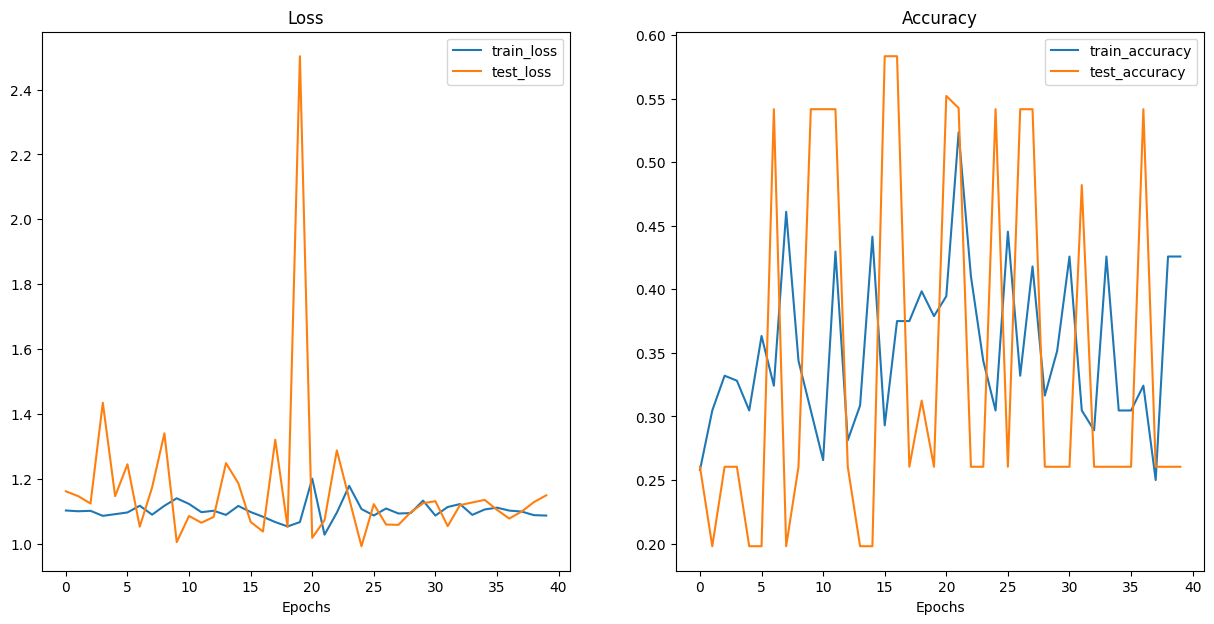

In [38]:
plot_loss_curves(model_results)